## Objective
Make RT-Sort spike assignment very fast

1 --> 2: 1 is development. 2 is getting it working with any sequences

## Setup

In [1]:
%load_ext autoreload

In [26]:
from math import ceil
from time import perf_counter

import numpy as np
import matplotlib.pyplot as plt
import torch

%autoreload 2
from src import utils

In [122]:
def sigmoid(x):
    exp = np.exp(x)
    return exp / (1 + exp)

In [56]:
TRACES = np.load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/traces.npy", mmap_mode="r")
OUTPUTS = np.load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/outputs.npy", mmap_mode="r")
ELEC_LOCS = np.load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/elec_locs.npy", mmap_mode="r")
# ALL_SEQUENCES = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/ground_truth_sequences.pickle")
ALL_SEQUENCES = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/230113/merged_sequences.pickle")

In [13]:
SAMP_FREQ = 32  # kHz
FRONT_BUFFER = 60
N_BEFORE = N_AFTER = round(0.5 * SAMP_FREQ)

In [14]:
elec_to_seqs = {}
for seq in ALL_SEQUENCES:
    if seq.root_elec not in elec_to_seqs:
        elec_to_seqs[seq.root_elec] = [seq]
    else:
        elec_to_seqs[seq.root_elec].append(seq)

In [25]:
for seq in elec_to_seqs[184]:
    print(seq.idx, seq.comp_elecs)
print()
for seq in elec_to_seqs[301]:
    print(seq.idx, seq.comp_elecs)

1 [184, 89, 280, 376, 281, 88]
49 [184, 88, 89, 281]

4 [301, 109, 205, 206]
85 [301, 12, 13, 14, 15, 299, 300, 302, 303, 304, 203, 204, 205, 206, 207, 208, 107, 108, 109, 110, 111]


In [652]:
def sigmoid_inverse(y):
    return -np.log(1 / y - 1)

# root_elec = 0
STRICT_THRESH_LOGIT = sigmoid_inverse(0.1)# -1.7346010553881064
LOOSE_THRESH_LOGIT = -2.1972245773362196

MIN_LOOSE_DETECTIONS_N = 3 
MIN_LOOSE_DETECTIONS_R = 2/3
MIN_INNER_LOOSE_DETECTIONS = 2

CLIP_LATENCY_DIFF = 5
CLIP_AMP_DIFF = 1

MAX_LATENCY_DIFF_SPIKES = 3#2.5
MAX_AMP_MEDIAN_DIFF_SPIKES = 0.35
MAX_ROOT_AMP_MEDIAN_STD = 2

MAX_DETECTIONS = round(0.5 * TRACES.shape[0])

OVERLAP = round(0.2 * SAMP_FREQ)
INNER_RADIUS = 50
OUTER_RADIUS = 100

In [174]:
def calc_elec_dist(elec1, elec2):
    # Calculate the spatial distance between two electrodes
    x1, y1 = ELEC_LOCS[elec1]
    x2, y2 = ELEC_LOCS[elec2]
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [443]:
# Setup
all_sequences = ALL_SEQUENCES[:50] # elec_to_seqs[184] + elec_to_seqs[301]
# all_sequences = [ALL_SEQUENCES[4], ALL_SEQUENCES[5]]
num_seqs = len(all_sequences)

all_comp_elecs = set()
seq_n_before = -np.inf
seq_n_after = -np.inf
seq_no_overlap_mask = torch.full((num_seqs, num_seqs), 0, dtype=torch.bool, device="cuda")
seq_idx_to_outer_elecs = {}
for a, seq in enumerate(all_sequences):
    all_comp_elecs.update(seq.comp_elecs)
    seq_n_before = max(seq_n_before, ceil(np.abs(np.min(seq.all_latencies[seq.comp_elecs]))) + CLIP_LATENCY_DIFF)
    seq_n_after = max(seq_n_after, ceil(np.abs(np.max(seq.all_latencies[seq.comp_elecs]))) + CLIP_LATENCY_DIFF)
    for b, seq_b in enumerate(all_sequences):
        if calc_elec_dist(seq.root_elec, seq_b.root_elec) > INNER_RADIUS:
            seq_no_overlap_mask[a, b] = 1
    outer_elecs = []
    for elec in range(len(ELEC_LOCS)):
        if calc_elec_dist(seq.root_elec, elec) <= OUTER_RADIUS:
            outer_elecs.append(elec)
    seq_idx_to_outer_elecs[a] = outer_elecs
        
all_comp_elecs = list(all_comp_elecs)

seqs_root_elecs = set()
seqs_root_elecs_rel_comp_elecs = []
seqs_inner_loose_elecs = []
seqs_min_inner_loose_elecs = []
seqs_loose_elecs = []
seqs_latencies = []
seqs_latency_weights = []
seqs_amps = []
seqs_root_amp_means = []
seqs_root_amp_stds = []
seqs_amp_weights = []
for seq in all_sequences: 
    seqs_root_elecs.add(seq.root_elec)
    seqs_root_elecs_rel_comp_elecs.append(all_comp_elecs.index(seq.root_elec))

    # Binary arrays (1 for comp_elec in inner_loose_elecs/loose_elecs, else 0)
    seqs_inner_loose_elecs.append(torch.tensor([1 if elec in seq.inner_loose_elecs else 0 for elec in all_comp_elecs], dtype=torch.bool, device="cuda"))
    seqs_loose_elecs.append(torch.tensor([1 if elec in seq.loose_elecs else 0 for elec in all_comp_elecs], dtype=torch.bool, device="cuda"))
    
    seqs_min_inner_loose_elecs.append(ceil(seq.min_loose_detections))
    
    seq_comp_elecs = set(seq.comp_elecs)
    seqs_latencies.append(torch.tensor([seq.all_latencies[elec] + seq_n_before if elec in seq_comp_elecs and elec != seq.root_elec else 0 for elec in all_comp_elecs], dtype=torch.float16, device="cuda"))
    seqs_amps.append(torch.tensor([seq.all_amp_medians[elec] if elec in seq_comp_elecs else 0 for elec in all_comp_elecs], dtype=torch.float16, device="cuda"))
    
    elec_probs = torch.tensor([seq.all_elec_probs[elec] if elec in seq_comp_elecs and elec != seq.root_elec else 0 for elec in all_comp_elecs], dtype=torch.float16, device="cuda")
    seqs_latency_weights.append(elec_probs/torch.sum(elec_probs))
    
    elec_probs = torch.tensor([seq.all_elec_probs[elec] if elec in seq_comp_elecs else 0 for elec in all_comp_elecs], dtype=torch.float16, device="cuda")
    seqs_amp_weights.append(elec_probs/torch.sum(elec_probs))
    
    seqs_root_amp_means.append(seq.all_amp_medians[seq.root_elec])
    seqs_root_amp_stds.append(seq.root_to_amp_median_std[seq.root_elec])
    
comp_elecs = torch.tensor(all_comp_elecs, dtype=torch.long, device="cuda")[:, None]
comp_elecs_flattened = comp_elecs.flatten()
    
seqs_root_elecs = list(seqs_root_elecs)
    
seqs_inner_loose_elecs = torch.vstack(seqs_inner_loose_elecs)
seqs_loose_elecs = torch.vstack(seqs_loose_elecs)
seqs_min_inner_loose_elecs = torch.tensor(seqs_min_inner_loose_elecs, dtype=torch.int16, device="cuda")
seqs_latencies = torch.vstack(seqs_latencies)
seqs_amps = torch.vstack(seqs_amps)
seqs_latency_weights = torch.vstack(seqs_latency_weights)
seqs_amp_weights = torch.vstack(seqs_amp_weights)
seqs_root_amp_means = torch.tensor(seqs_root_amp_means, dtype=torch.float16, device="cuda")
seqs_root_amp_stds = torch.tensor(seqs_root_amp_stds, dtype=torch.float16, device="cuda")
    
# for seq in ALL_SEQUENCES:
#     seq.nor_comp_elecs = seq.comp_elecs[1:]
    
#     # elec_rel_comp_elec = {comp_elec: i for i, comp_elec in enumerate(seq.comp_elecs)}  # After slicing with comp_elecs, loose and inner loose elecs need to be relative to comp_elec
#     # seq.test_inner_loose_elecs = torch.tensor([elec_rel_comp_elec[elec] for elec in seq.inner_loose_elecs], dtype=torch.int32, device="cuda")
#     # seq.test_loose_elecs = torch.tensor([elec_rel_comp_elec[elec] for elec in seq.loose_elecs], dtype=torch.int32, device="cuda")
#     seq.test_inner_loose_elecs = torch.tensor([1 if elec in seq.inner_loose_elecs else 0 for elec in seq.comp_elecs], dtype=torch.bool, device="cuda")  # Binary array (1 for comp_elec in inner_loose_elecs, else 0)
#     seq.test_loose_elecs = torch.tensor([1 if elec in seq.loose_elecs else 0 for elec in seq.comp_elecs], dtype=torch.bool, device="cuda")  # Binary array (1 for comp_elec in loose_elecs, else 0)
    
#     seq.test_latencies = torch.tensor(seq.all_latencies[seq.nor_comp_elecs], dtype=torch.float16, device="cuda")
#     seq.test_amps = torch.tensor(seq.all_amp_medians[seq.comp_elecs], dtype=torch.float16, device="cuda")
    
#     elec_probs = seq.all_elec_probs[seq.comp_elecs]
#     seq.test_latency_weights = torch.tensor(elec_probs[1:]/np.sum(elec_probs[1:]), dtype=torch.float16, device="cuda")
#     seq.test_amp_weights = torch.tensor(elec_probs/np.sum(elec_probs), dtype=torch.float16, device="cuda")
    
max_pool = torch.nn.MaxPool1d(seq_n_before+seq_n_after+1, return_indices=True)

In [640]:
# TEST_TIME = 315.125
TEST_TIME = 22681.78125

In [641]:
strict_thresh_logit = sigmoid_inverse(0.1)

In [741]:
torch.backends.cudnn.benchmark = True

In [897]:
torch.cuda.empty_cache()
num_seqs = len(all_sequences)
detections = [[] for _ in range(num_seqs)]

# NUM_SEQS = 60

# seq = ALL_SEQUENCES[4]
# latencies = seq.all_latencies[seq.comp_elecs]
# seq_n_before = ceil(np.abs(np.min(latencies))) + CLIP_LATENCY_DIFF
# seq_n_after = ceil(np.max(latencies)) + CLIP_LATENCY_DIFF 

# comp_elecs = torch.tensor(seq.comp_elecs, device="cuda")[:, None]
# comp_elecs_flattened = comp_elecs.flatten()

# nor_comp_elecs = seq.nor_comp_elecs

# max_pool = torch.nn.MaxPool1d(seq_n_before+seq_n_after+1, return_indices=True)

N_BEFORE = N_AFTER = round(0.5 * SAMP_FREQ)
output_frame = round(TEST_TIME * SAMP_FREQ) - FRONT_BUFFER
output_window = OUTPUTS[:, output_frame-90:output_frame+90]
torch_window = torch.tensor(output_window, device="cuda")

# samp_elecs = [0, 1, 2, 3, 4]

# seqs_root_elecs = [seq.root_elec for _ in range(NUM_SEQS)] # [seq.root_elec for i in range(NUM_SEQS)]
# seqs_root_elecs_rel_comp_elecs = [list(comp_elecs).index(root_elec) for root_elec in seqs_root_elecs]
# seqs_template_inner_loose_elecs = torch.vstack([seq.test_inner_loose_elecs for i in range(NUM_SEQS)])
# seqs_min_inner_loose_elecs = torch.tensor([seq.min_loose_detections for i in range(NUM_SEQS)], dtype=torch.float16, device="cuda")
# seqs_template_loose_elecs = torch.vstack([seq.test_loose_elecs for i in range(NUM_SEQS)])

# seqs_template_latencies = torch.vstack([seq.test_latencies for i in range(NUM_SEQS)]) + seq_n_before  # +seq_n_before so offset relative to window
# seqs_latency_weights = torch.vstack([seq.test_latency_weights for i in range(NUM_SEQS)])

# seqs_template_amps = torch.vstack([seq.test_amps for i in range(NUM_SEQS)])
# seqs_root_amp_mean = torch.tensor([seq.all_amp_medians[seq.root_elec] for i in range(NUM_SEQS)], dtype=torch.float16, device="cuda")
# seqs_root_amp_std = torch.tensor([seq.root_to_amp_median_std[seq.root_elec] for i in range(NUM_SEQS)], dtype=torch.float16, device="cuda")
# seqs_amp_weights = torch.vstack([seq.test_amp_weights for i in range(NUM_SEQS)])

# for thing in (seqs_template_latencies, seqs_latency_weights, seqs_template_amps, seqs_amp_weights):
#     thing *= torch.randn_like(thing)

pre_frames = round(50 * SAMP_FREQ)
rec_frame = round(TEST_TIME * SAMP_FREQ)
pre_medians = TRACES[:, rec_frame-pre_frames:rec_frame]
pre_medians = np.median(np.abs(pre_medians), axis=1)
pre_medians = np.clip(pre_medians / 0.6745, a_min=0.5, a_max=None) 
pre_medians = torch.tensor(pre_medians, dtype=torch.float16, device="cuda")

rec_window = torch.tensor(TRACES[:, rec_frame-90:rec_frame+90], dtype=torch.float16, device="cuda")
rec_window_size = 90+90
spike_arange = torch.arange(0, seq_n_before+seq_n_after+1, device="cuda")# torch.arange(-seq_n_before, seq_n_after+1, device="cuda")

start_time = perf_counter()

pre_medians_comp = pre_medians[comp_elecs_flattened]

window = torch_window[seqs_root_elecs, seq_n_before-1:-seq_n_after+1] # -1 and +1 to identify peaks
main = window[:, 1:-1]
greater_than_left = main > window[:, :-2]
greater_than_right = main > window[:, 2:]
# window = torch_window[:NUM_ELECS] # -1 and +1 to identify peaks
# main = window[:, seq_n_before:-seq_n_after]
# greater_than_left = main > window[:, seq_n_before-1:-seq_n_after-1]
# greater_than_right = main > window[:, seq_n_before+1:-seq_n_after+1]
peaks = greater_than_left & greater_than_right
crosses = main >= STRICT_THRESH_LOGIT
peak_ind_flat = torch.nonzero(peaks & crosses, as_tuple=True)[1] # now done in spike_arange: + seq_n_before
peak_ind_flat = peak_ind_flat[torch.sum(torch_window[:, peak_ind_flat+seq_n_before] >= LOOSE_THRESH_LOGIT, dim=0) <= MAX_DETECTIONS]  # can take about 0.5-2ms
peak_ind = peak_ind_flat[:, None, None]  # Relative to seq_n_before in output_window

assert torch.numel(peak_ind) > 0

# spike_window = torch.stack([torch_window[comp_elecs, idx-seq_n_before:idx+seq_n_after+1] for idx in peak_ind if seq_n_before <= idx+1 < rec_window_size-seq_n_after])
spike_window = torch_window[comp_elecs, peak_ind + spike_arange] 

elec_probs, latencies = max_pool(spike_window)  # Latencies are relative to peak-seq_n_before

elec_crosses = (elec_probs >= LOOSE_THRESH_LOGIT).transpose(1, 2)
num_inner_loose = torch.sum(elec_crosses & seqs_inner_loose_elecs, dim=2)
pass_inner_loose = num_inner_loose >= MIN_INNER_LOOSE_DETECTIONS

num_loose = torch.sum(elec_crosses & seqs_loose_elecs, dim=2)
pass_loose = num_loose >= seqs_min_inner_loose_elecs

can_spike = pass_inner_loose & pass_loose
# if not np.any(can_spike): continue

latencies_float = latencies.transpose(1, 2).to(torch.float16)
latency_diff = torch.abs(latencies_float - seqs_latencies)
latency_diff = torch.clip(latency_diff, min=None, max=CLIP_LATENCY_DIFF)
latency_diff = torch.sum(latency_diff * seqs_latency_weights, axis=2)
pass_latency = latency_diff <= MAX_LATENCY_DIFF_SPIKES

# region
amps = torch.abs(rec_window[comp_elecs, peak_ind + latencies].transpose(1, 2)) / pre_medians_comp  # peak_ind+seq_n_before = peak_ind_in_rec_window. latency-seq_n_before = latency_rel_peak_ind. --> (peak_ind+seq_n_before)+(latency-seq_n_before) = peak_ind+latency = spike index in rec_window

root_amp_z = torch.abs(amps[:, 0, seqs_root_elecs_rel_comp_elecs] - seqs_root_amp_means) / seqs_root_amp_stds
pass_root_amp_z = root_amp_z <= MAX_ROOT_AMP_MEDIAN_STD

amp_diff = torch.abs(amps - seqs_amps) / seqs_amps
amp_diff = torch.clip(amp_diff, min=None, max=CLIP_AMP_DIFF)
amp_diff = torch.sum(amp_diff * seqs_amp_weights, axis=2)
pass_amp_diff = amp_diff <= MAX_AMP_MEDIAN_DIFF_SPIKES

can_spike = pass_inner_loose & pass_loose & pass_latency & pass_root_amp_z & pass_amp_diff

# Slighty faster than the following due to only slicing once: # spike_scores = latency_diff[can_spike] / MAX_LATENCY_DIFF_SPIKES + amp_diff[can_spike] / MAX_AMP_MEDIAN_DIFF_SPIKES  - num_loose[can_spike] / torch.sum(elec_crosses, dim=2)
spike_scores = latency_diff / MAX_LATENCY_DIFF_SPIKES + amp_diff / MAX_AMP_MEDIAN_DIFF_SPIKES - num_loose / torch.sum(elec_crosses, dim=2)
spike_scores = 2.1 - spike_scores  # (additional 0.1 in case spike_scores=2)
# spike_scores = spike_scores[can_spike]
# spike_scores = torch.topk(spike_scores, 2)

spike_scores *= can_spike

peak_ind_2d = peak_ind[:, 0]
while torch.any(spike_scores):
    spike_seq_idx = torch.argmax(spike_scores).item()
    spike_idx = spike_seq_idx // num_seqs
    seq_idx = spike_seq_idx % num_seqs
    spike_time = peak_ind_flat[spike_idx]
    # region Only one spike within OVERLAP
    spike_scores *= seq_no_overlap_mask[seq_idx] & (torch.abs(peak_ind_2d - spike_time) > OVERLAP)
    detections[seq_idx].append(spike_time + seq_n_before)
    # endregion
        
    # region Allow multiple spikes within OVERLAP.
    # spike_time = peak_ind[spike_idx] + seq_n_before
    # above_thresh = torch_window[seq_idx_to_outer_elecs[seq_idx], spike_time-N_BEFORE:spike_time+N_AFTER+1] >= LOOSE_THRESH_LOGIT
    # peaks = ~above_thresh[:, :-1] & above_thresh[:, 1:]
    # num_spikes = torch.sum(peaks, dim=1)
    # num_spikes = torch.max(num_spikes)
    # spike_seq_ind = torch.topk(spike_scores.flatten(), num_spikes, sorted=False).indices
    # for spike_seq_idx in spike_seq_ind:
    #     spike_seq_idx = spike_seq_idx.item()
    #     spike_idx = spike_seq_idx // num_seqs
    #     seq_idx = spike_seq_idx % num_seqs
    #     spike_time = peak_ind_flat[spike_idx]
    #     spike_scores *= seq_no_overlap_mask[seq_idx] & (torch.abs(peak_ind_2d - spike_time) > OVERLAP)
    #     detections[seq_idx].append(spike_time + seq_n_before)
    # endregion
        
torch.cuda.synchronize()
end_time = perf_counter()
print((end_time-start_time)*1000)
print(detections)
# print(latency_diff)
# print(amp_diff)

# sigmoided = sigmoid6(output_window)
# plt.plot(sigmoided)
# plt.scatter(peaks, sigmoided[peaks], color="orange")
# plt.show()

4.522452014498413
[[], [], [], [], [tensor(90, device='cuda:0')], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


In [932]:
import torch_tensorrt

class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
    
    def forward(self, torch_window):
        window = torch_window[seqs_root_elecs, seq_n_before-1:-seq_n_after+1] # -1 and +1 to identify peaks
        main = window[:, 1:-1]
        greater_than_left = main > window[:, :-2]
        greater_than_right = main > window[:, 2:]
        # window = torch_window[:NUM_ELECS] # -1 and +1 to identify peaks
        # main = window[:, seq_n_before:-seq_n_after]
        # greater_than_left = main > window[:, seq_n_before-1:-seq_n_after-1]
        # greater_than_right = main > window[:, seq_n_before+1:-seq_n_after+1]
        peaks = greater_than_left & greater_than_right
        crosses = main >= STRICT_THRESH_LOGIT
        peak_ind_flat = torch.nonzero(peaks & crosses, as_tuple=True)[1] # now done in spike_arange: + seq_n_before
        peak_ind_flat = peak_ind_flat[torch.sum(torch_window[:, peak_ind_flat+seq_n_before] >= LOOSE_THRESH_LOGIT, dim=0) <= MAX_DETECTIONS]  # can take about 0.5-2ms
        peak_ind = peak_ind_flat[:, None, None]  # Relative to seq_n_before in output_window
        assert torch.numel(peak_ind) > 0

        # spike_window = torch.stack([torch_window[comp_elecs, idx-seq_n_before:idx+seq_n_after+1] for idx in peak_ind if seq_n_before <= idx+1 < rec_window_size-seq_n_after])
        spike_window = torch_window[comp_elecs, peak_ind + spike_arange] 

        elec_probs, latencies = max_pool(spike_window)  # Latencies are relative to peak-seq_n_before

        elec_crosses = (elec_probs >= LOOSE_THRESH_LOGIT).transpose(1, 2)
        num_inner_loose = torch.sum(elec_crosses & seqs_inner_loose_elecs, dim=2)
        pass_inner_loose = num_inner_loose >= MIN_INNER_LOOSE_DETECTIONS

        num_loose = torch.sum(elec_crosses & seqs_loose_elecs, dim=2)
        pass_loose = num_loose >= seqs_min_inner_loose_elecs

        can_spike = pass_inner_loose & pass_loose
        # if not np.any(can_spike): continue

        latencies_float = latencies.transpose(1, 2).to(torch.float16)
        latency_diff = torch.abs(latencies_float - seqs_latencies)
        latency_diff = torch.clip(latency_diff, min=None, max=CLIP_LATENCY_DIFF)
        latency_diff = torch.sum(latency_diff * seqs_latency_weights, axis=2)
        pass_latency = latency_diff <= MAX_LATENCY_DIFF_SPIKES

        # region
        amps = torch.abs(rec_window[comp_elecs, peak_ind + latencies].transpose(1, 2)) / pre_medians_comp  # peak_ind+seq_n_before = peak_ind_in_rec_window. latency-seq_n_before = latency_rel_peak_ind. --> (peak_ind+seq_n_before)+(latency-seq_n_before) = peak_ind+latency = spike index in rec_window

        root_amp_z = torch.abs(amps[:, 0, seqs_root_elecs_rel_comp_elecs] - seqs_root_amp_means) / seqs_root_amp_stds
        pass_root_amp_z = root_amp_z <= MAX_ROOT_AMP_MEDIAN_STD

        amp_diff = torch.abs(amps - seqs_amps) / seqs_amps
        amp_diff = torch.clip(amp_diff, min=None, max=CLIP_AMP_DIFF)
        amp_diff = torch.sum(amp_diff * seqs_amp_weights, axis=2)
        pass_amp_diff = amp_diff <= MAX_AMP_MEDIAN_DIFF_SPIKES

        can_spike = pass_inner_loose & pass_loose & pass_latency & pass_root_amp_z & pass_amp_diff

        # Slighty faster than the following due to only slicing once: # spike_scores = latency_diff[can_spike] / MAX_LATENCY_DIFF_SPIKES + amp_diff[can_spike] / MAX_AMP_MEDIAN_DIFF_SPIKES  - num_loose[can_spike] / torch.sum(elec_crosses, dim=2)
        spike_scores = latency_diff / MAX_LATENCY_DIFF_SPIKES + amp_diff / MAX_AMP_MEDIAN_DIFF_SPIKES - num_loose / torch.sum(elec_crosses, dim=2)
        spike_scores = 2.1 - spike_scores  # (additional 0.1 in case spike_scores=2)
        # spike_scores = spike_scores[can_spike]
        # spike_scores = torch.topk(spike_scores, 2)

        spike_scores *= can_spike
        
        peak_ind_2d = peak_ind[:, 0]
        
        return spike_scores, peak_ind_2d
        
        detections = []
        while torch.any(spike_scores):
            spike_seq_idx = torch.argmax(spike_scores)
            spike_idx = spike_seq_idx // num_seqs
            seq_idx = spike_seq_idx % num_seqs
            spike_time = peak_ind_flat[spike_idx]
            # region Only one spike within OVERLAP
            spike_scores *= seq_no_overlap_mask[seq_idx] & (torch.abs(peak_ind_2d - spike_time) > OVERLAP)
            detections.append(seq_idx)
            detections.append(spike_time)
            # detections[seq_idx].append(spike_time + seq_n_before)
            # endregion
                
            # region Allow multiple spikes within OVERLAP.
            # spike_time = peak_ind[spike_idx] + seq_n_before
            # above_thresh = torch_window[seq_idx_to_outer_elecs[seq_idx], spike_time-N_BEFORE:spike_time+N_AFTER+1] >= LOOSE_THRESH_LOGIT
            # peaks = ~above_thresh[:, :-1] & above_thresh[:, 1:]
            # num_spikes = torch.sum(peaks, dim=1)
            # num_spikes = torch.max(num_spikes)
            # spike_seq_ind = torch.topk(spike_scores.flatten(), num_spikes, sorted=False).indices
            # for spike_seq_idx in spike_seq_ind:
            #     spike_seq_idx = spike_seq_idx.item()
            #     spike_idx = spike_seq_idx // num_seqs
            #     seq_idx = spike_seq_idx % num_seqs
            #     spike_time = peak_ind_flat[spike_idx]
            #     spike_scores *= seq_no_overlap_mask[seq_idx] & (torch.abs(peak_ind_2d - spike_time) > OVERLAP)
            #     detections[seq_idx].append(spike_time + seq_n_before)
            # endregion
        return detections
    
torch_window = torch.tensor(output_window, device="cuda")
rec_window = torch.tensor(TRACES[:, rec_frame-90:rec_frame+90], dtype=torch.float16, device="cuda")

model = Model()
model = torch.jit.trace(model, [torch_window])
# model = torch_tensorrt.compile(model, inputs=[torch_tensorrt.Input((384, 180), dtype=torch.float16)], enabled_precisions={torch.float16}, truncate_long_and_double=True)

In [630]:
pre_frames = round(50 * SAMP_FREQ)

torch.cuda.empty_cache() 
value = np.random.randint(1000, 10000)
rec_frame = round(value * SAMP_FREQ)
pre_medians = torch.tensor(TRACES[all_comp_elecs, rec_frame-pre_frames:rec_frame], dtype=torch.float16, device="cuda")

start = perf_counter()

pre_medians = torch.median(torch.abs(pre_medians), dim=1).values
# pre_medians = torch.clip(pre_medians / 0.6745, a_min=0.5, a_max=None) 

torch.cuda.synchronize()
end = perf_counter()
(end - start)*1000

7526


0.34784001763910055

In [973]:
pre_frames = round(50 * SAMP_FREQ)

detections = []
start = perf_counter()

spike_scores, peak_ind_2d = model(torch_window)
while torch.any(spike_scores):
    spike_seq_idx = torch.argmax(spike_scores).item()
    spike_idx = spike_seq_idx // num_seqs
    seq_idx = spike_seq_idx % num_seqs
    spike_time = peak_ind_flat[spike_idx]
    # region Only one spike within OVERLAP
    spike_scores *= seq_no_overlap_mask[seq_idx] & (torch.abs(peak_ind_2d - spike_time) > OVERLAP)
    detections.append(seq_idx)
    detections.append(spike_time)

torch.cuda.synchronize()
end = perf_counter()
(end - start)*1000

3.0458029941655695

In [918]:
test

tensor([[-0.0000, -0.0000, 0.0000, 0.0000, 1.4289, 0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000, 0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000

In [769]:
torch.tensor([  # (chans, samples)
    [0, 1, 2, 3, 4, 5],
    [6, 7, 8, 9, 10, 11],
    [12, 13, 14, 15, 16, 17],
    [18, 19, 20, 21, 22, 23]
])[
    [[0], [1]],
    [[[0, 1, 2]]]
]

tensor([[[0, 1, 2],
         [6, 7, 8]]])

In [783]:
torch.tensor([  # (chans, samples)
    [0, 1, 2, 3, 4, 5],
    [6, 7, 8, 9, 10, 11],
    [12, 13, 14, 15, 16, 17],
    [18, 19, 20, 21, 22, 23]
])[        
    [[0, 1],
     [2, 3]],
    
    [[[0, 1]],
     [[2, 3]]]
]

tensor([[[ 0,  7],
         [12, 19]],

        [[ 2,  9],
         [14, 21]]])

In [717]:
np.array([[[0, 1, 2]], [[2, 3, 4]]]).shape

(2, 1, 3)

In [615]:
torch.tensor([[  # (chans, samples)
    [0, 1, 2, 3, 4, 5],
    [6, 7, 8, 9, 10, 11],
    [12, 13, 14, 15, 16, 17],
    [18, 19, 20, 21, 22, 23]
]])[    
    [0, 0],
    [[[0], [1]], [[2], [3]]],
    [[[0, 1], [0, 1]], [[2, 3], [2, 3]]],
    
]

tensor([[[ 0,  1],
         [ 6,  7]],

        [[14, 15],
         [20, 21]]])

In [182]:
torch_window[
    [comp_elecs]*len(peak_ind),
    peak_ind+spike_arange
]

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [2, 13], [2, 26]

In [161]:
arange = torch.arange(10, device="cuda")
start_time = perf_counter()
torch_window[
    peak_ind,
    peak_ind+arange
]
end_time = perf_counter()
print((end_time - start_time)*1000)

0.23681597667746246


In [111]:
torch.tensor([
    [0, 1, 2],
    [3, 4, 5]
])[slice(0, 1), [slice(0, 2), slice(0, 2)]]

RuntimeError: Could not infer dtype of slice

In [109]:
torch.tensor([0, 1, 2])[slice(0, 2)]

tensor([0, 1])

In [279]:
torch.cuda.empty_cache()
NUM_SEQS = 4

seq = ALL_SEQUENCES[4]
latencies = seq.all_latencies[seq.comp_elecs]
seq_n_before = ceil(np.abs(np.min(latencies))) + CLIP_LATENCY_DIFF
seq_n_after = ceil(np.max(latencies)) + CLIP_LATENCY_DIFF 
comp_elecs = seq.comp_elecs
nor_comp_elecs = seq.nor_comp_elecs

max_pool = torch.nn.MaxPool1d(seq_n_before+seq_n_after+1, return_indices=True)

torch_window = torch.tensor(output_window, device="cuda")

# seqs_root_elecs = [seq.root_elec for i in range(NUM_SEQS)]
seqs_template_latencies = torch.vstack([seq.test_latencies+i for i in range(NUM_SEQS)])
seqs_latency_weights = torch.vstack([seq.test_latency_weights+i for i in range(NUM_SEQS)])
seqs_template_amps = torch.vstack([seq.test_amps+i for i in range(NUM_SEQS)])
seqs_amp_weights = torch.vstack([seq.test_amp_weights+i for i in range(NUM_SEQS)])

pre_frames = round(50 * SAMP_FREQ)
rec_frame = round(TEST_TIME * SAMP_FREQ)
pre_medians = TRACES[:, rec_frame-pre_frames:rec_frame]
pre_medians = np.median(np.abs(pre_medians), axis=1)
pre_medians = np.clip(pre_medians / 0.6745, a_min=0.5, a_max=None) 
pre_medians = torch.tensor(pre_medians, dtype=torch.float16, device="cuda")

rec_window = torch.tensor(TRACES[:, rec_frame-90:rec_frame+90], dtype=torch.float16, device="cuda")

start_time = perf_counter()

# for win in window:
#     main = win[1:-1]
#     greater_than_left = main > win[:-2]
#     greater_than_right = main > win[2:]
#     peaks = greater_than_left & greater_than_right

# main = window[:, 1:-1]
# greater_than_left = main > window[:, :-2]
# greater_than_right = main > window[:, 2:]
# peaks = greater_than_left & greater_than_right
# for p in peaks:
#     np.flatnonzero(p)

for _ in range(1):
    window = torch_window[seq.root_elec]
    main = window[1:-1]
    greater_than_left = main > window[:-2]
    greater_than_right = main > window[2:]
    peaks = greater_than_left & greater_than_right
    crosses = main >= strict_thresh_logit
    peak_ind = torch.nonzero(peaks & crosses) + 1

    pre_medians_comp = pre_medians[comp_elecs]
    for idx in peak_ind:
        spike_window = torch_window[comp_elecs, idx-seq_n_before:idx+seq_n_after+1]
        elec_probs, latencies = max_pool(spike_window)
        latencies = latencies.flatten()
        
        latencies_float = latencies.to(torch.float16) - seq_n_before
        latency_diff = torch.abs(latencies_float[1:] - seqs_template_latencies)
        latency_diff = torch.clip(latency_diff, max=CLIP_LATENCY_DIFF)
        latency_diff = torch.sum(latency_diff * seqs_latency_weights, axis=1)

        amps = torch.abs(rec_window[comp_elecs, idx-seq_n_before+latencies]) / pre_medians_comp
        amp_diff = torch.abs(amps - seqs_template_amps) / seqs_template_amps
        amp_diff = torch.clip(amp_diff, max=CLIP_AMP_DIFF)
        amp_diff = torch.sum(amp_diff * seqs_amp_weights, axis=1)
        break
        
# for _ in range(10):
#     for idx in peak_ind:
#         # for seq in elec_to_seqs[root_elec]:
#         #     if torch.sum(elec_probs[seq.inner_loose_elecs] >= loose_thresh_logit) < MIN_INNER_LOOSE_DETECTIONS:
#         #         continue
            
#         #     if torch.sum(elec_probs[seq.loose_elecs] >= loose_thresh_logit) < MIN_LOOSE_DETECTIONS_N:
#         #         continue
            
            
#         #     # latency_diff = latencies[seq.nor_comp_elecs] - seq.test_latencies
#         #     latency_diff = torch.sum(latencies[seq.nor_comp_elecs] * seq.test_latency_elec_probs)
#         # latency_diff = torch.abs((latencies[1:] - latencies[0]) - seqs_latencies)
#         seqs_latencies = seqs_template_latencies + latencies[seqs_root_elecs][:, None]
#         comp_latencies = latencies[seq.nor_comp_elecs]
#         latency_diff = torch.abs(comp_latencies - seqs_latencies)
#         latency_diff = torch.clip(latency_diff, max=CLIP_LATENCY_DIFF)
#         latency_diff = torch.sum(latency_diff * seqs_latency_weights, axis=1)
        
    # elec_probs, latencies = torch.max(torch_window[seq.comp_elecs], axis=1)
    # if torch.sum(elec_probs[seq.test_inner_elecs] >= loose_thresh_logit) < 2:
    #     continue

torch.cuda.synchronize()
end_time = perf_counter()
print((end_time-start_time)*1000)
print(latency_diff)
print(amp_diff)

# sigmoided = sigmoid(output_window)
# plt.plot(sigmoided)
# plt.scatter(peaks, sigmoided[peaks], color="orange")
# plt.show()

1.9555579929146916
tensor([  1.8779,  41.1250,  85.2500, 138.2500], device='cuda:0',
       dtype=torch.float16)
tensor([ 0.1903,  4.8125, 13.2422, 23.2656], device='cuda:0',
       dtype=torch.float16)


In [271]:
seqs_amp_weights[0]

tensor([0.4324, 0.0000, 0.1692, 0.1495, 0.1495, 0.0997, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0', dtype=torch.float16)

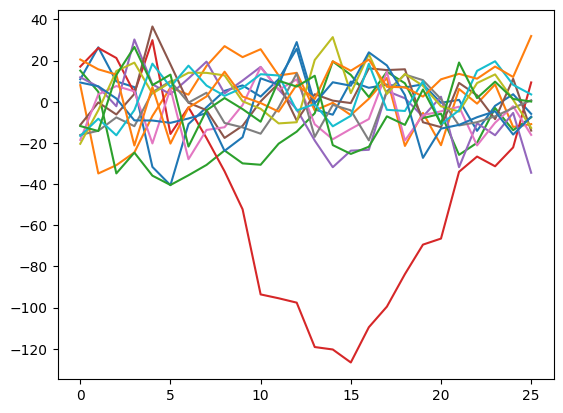

In [261]:
plt.plot(rec_window[arange_comp_elecs, idx-seq_n_before:idx+seq_n_after+1].T.cpu())
plt.show()

In [40]:
torch.cuda.empty_cache()
NUM_SEQS = 4

seq = ALL_SEQUENCES[4]
torch_window = torch.tensor(output_window, device="cuda")
arange = torch.arange(N_BEFORE+N_AFTER+1-2) # np.arange(1, output_window.size-1)
window_size = N_BEFORE + N_AFTER + 1

seqs_root_elecs = [seq.root_elec for i in range(NUM_SEQS)]
seqs_template_latencies = torch.vstack([seq.test_latencies+i for i in range(NUM_SEQS)])
seqs_latency_weights = torch.vstack([seq.test_latency_weights+i for i in range(NUM_SEQS)])

start_time = perf_counter()



window = torch_window[seq.root_elec]
main = window[1:-1]
greater_than_left = main > window[:-2]
greater_than_right = main > window[2:]
peaks = greater_than_left & greater_than_right
crosses = main >= strict_thresh_logit
peak_ind = torch.nonzero(peaks & crosses) + 1

elec_probs, latencies = torch.nn.functional.max_pool1d(torch_window, window_size, return_indices=True)
latencies = latencies.to(torch.float16).flatten()

for _ in range(10):
    for idx in peak_ind:
        # for seq in elec_to_seqs[root_elec]:
        #     if torch.sum(elec_probs[seq.inner_loose_elecs] >= loose_thresh_logit) < MIN_INNER_LOOSE_DETECTIONS:
        #         continue
            
        #     if torch.sum(elec_probs[seq.loose_elecs] >= loose_thresh_logit) < MIN_LOOSE_DETECTIONS_N:
        #         continue
            
            
        #     # latency_diff = latencies[seq.nor_comp_elecs] - seq.test_latencies
        #     latency_diff = torch.sum(latencies[seq.nor_comp_elecs] * seq.test_latency_elec_probs)
        # latency_diff = torch.abs((latencies[1:] - latencies[0]) - seqs_latencies)
        seqs_latencies = seqs_template_latencies + latencies[seqs_root_elecs][:, None]
        comp_latencies = latencies[seq.nor_comp_elecs]
        latency_diff = torch.abs(comp_latencies - seqs_latencies)
        latency_diff = torch.clip(latency_diff, max=CLIP_LATENCY_DIFF)
        latency_diff = torch.sum(latency_diff * seqs_latency_weights, axis=1)
        
    # elec_probs, latencies = torch.max(torch_window[seq.comp_elecs], axis=1)
    # if torch.sum(elec_probs[seq.test_inner_elecs] >= loose_thresh_logit) < 2:
    #     continue

torch.cuda.synchronize()
end_time = perf_counter()
print((end_time-start_time)*1000)
print(latency_diff)

# sigmoided = sigmoid(output_window)
# plt.plot(sigmoided)
# plt.scatter(peaks, sigmoided[peaks], color="orange")
# plt.show()

6.905371003085747
tensor([  2.9609,  52.6875, 106.0625, 161.2500], device='cuda:0',
       dtype=torch.float16)


In [ ]:
latencies[seqs_root_elecs][:, None]

tensor([[16.],
        [16.],
        [16.],
        [16.]], device='cuda:0', dtype=torch.float16)

In [ ]:
latencies.T

/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)
  """Entry point for launching an IPython kernel.


tensor([ 7.,  5.,  7., 16., 16., 10.,  1., 24., 29., 32., 23.,  6., 18., 32.,
         4., 32., 19.,  4.,  8., 24., 31., 21.,  6., 21., 26., 15., 17.,  0.,
         3.,  0.,  8., 32., 24., 22., 26., 28., 32.,  0., 28., 14., 18., 31.,
         0.,  0.,  5., 30., 25., 29., 25.,  1.,  0., 18., 28., 27., 28., 27.,
        29.,  6.,  7.,  7.,  9., 28., 26., 27., 29., 23., 17.,  0.,  9., 17.,
         3.,  0., 24., 21., 32., 32.,  3., 31., 28., 19.,  1., 21., 22.,  5.,
         8., 29., 11.,  5., 12., 23., 21., 32.,  2., 26.,  9., 32.,  7.,  7.,
        10.,  0., 25., 28.,  0., 11., 25.,  2., 24.,  7.,  9.,  5.,  0., 32.,
        12., 30., 29.,  3., 28., 28., 28.,  2., 15.,  0., 20.,  1.,  1., 29.,
        25., 19.,  6., 16., 23., 31.,  7.,  1., 24., 12., 21., 30., 20.,  2.,
        23., 13.,  5.,  3.,  4., 30., 31., 27., 26., 28., 28., 28., 19., 15.,
         7.,  8., 15., 22., 32., 19., 23.,  6.,  0., 29.,  1.,  0.,  7.,  1.,
         0., 32., 29.,  3., 19., 32., 21.,  0., 16.,  4., 28., 3